# AS-Bridge Inference (Shared)

Generate predictions for a selected subset of test samples and visualize all results.



In [ ]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import yaml
sys.path.append('AS-Bridge/scirpts')


config_path = Path('AS-Bridge/scirpts/config.yaml')
ckpt_path = Path('AS-Bridge/ckpts/eps/last.pth')

# Test data: one or more Zarr groups containing paired {source_key, target_key} arrays.
test_zarr_paths = [Path('AS-Bridge/test-data/nonlens')]
# ---- Controls ----
num_test_examples = 128
seed_indices = 123

# prediction target: 'euclid', 'lsst', or 'both'
pred_target = 'lsst'

# mixing alpha: y = alpha*LSST + (1-alpha)*Euclid
# alpha=1.0 => start from LSST
start_alpha = 0.0

# number of samples to generate (K)
num_generations = 5
sampling_seed0 = 2025
sampling_seeds = list(range(int(sampling_seed0), int(sampling_seed0) + int(num_generations)))

# sampling steps (None uses model.steps)
num_sampling_steps = 50

batch_size = 128

# ---------------------------------



In [2]:
# --- Build model + load checkpoint ---
from model import BrownianBridge
from unet import UNet

cfg = yaml.safe_load(config_path.read_text())
data_cfg = cfg.get('data', {})
model_cfg = cfg.get('model', {})

channels = int(model_cfg.get('channels', 3))
net = UNet(
    in_channels=channels * 3,
    out_channels=channels * 2,
    base_channels=int(model_cfg.get('base_channels', 64)),
    channel_mults=tuple(model_cfg.get('channel_mults', [1, 2, 4])),
    num_res_blocks=int(model_cfg.get('num_res_blocks', 2)),
    time_dim=int(model_cfg.get('time_dim', 256)),
)

model = BrownianBridge(
    denoise_fn=net,
    num_timesteps=int(model_cfg.get('num_timesteps', 1000)),
    mt_type=str(model_cfg.get('mt_type', 'linear')),
    max_var=float(model_cfg.get('max_var', 1.0)),
    eta=float(model_cfg.get('eta', 1.0)),
    objective=str(model_cfg.get('objective', 'eps')),
    loss_type=str(model_cfg.get('loss_type', 'mse')),
    channels=channels,
    skip_sample=bool(model_cfg.get('skip_sample', False)),
    sample_type=str(model_cfg.get('sample_type', 'linear')),
    sample_step=int(model_cfg.get('sample_step', 200)),
)

ckpt = torch.load(ckpt_path, map_location='cpu')
state = ckpt.get('model', ckpt)
model.load_state_dict(state, strict=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()


BrownianBridge(
  (denoise_fn): UNet(
    (time_embed): Sequential(
      (0): SinusoidalTimeEmbedding()
      (1): Linear(in_features=256, out_features=1024, bias=True)
      (2): SiLU()
      (3): Linear(in_features=1024, out_features=256, bias=True)
    )
    (dir_embed): Embedding(2, 256)
    (init_conv): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResBlock(
          (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_mlp): Linear(in_features=256, out_features=128, bias=True)
          (act): SiLU()
          (skip): Identity()
        )
      )
      (1): ModuleList(
        (0): ResBlock(
          (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)

In [3]:
# --- Load test dataset (subset with fixed seed) ---
from torch.utils.data import ConcatDataset, DataLoader, Subset
from dataset import ZarrPairDataset

source_key = data_cfg.get('source_key', 'lsst')
target_key = data_cfg.get('target_key', 'euclid')
euclid_to_rgb = bool(data_cfg.get('euclid_to_rgb', True))

test_zarr_paths = [Path(p) for p in test_zarr_paths]
datasets = [
    ZarrPairDataset(p, source_key=source_key, target_key=target_key, euclid_to_rgb=euclid_to_rgb)
    for p in test_zarr_paths
]

test_ds = datasets[0] if len(datasets) == 1 else ConcatDataset(datasets)

total = len(test_ds)
num_test_examples = min(int(num_test_examples), int(total))

rng = np.random.default_rng(seed=seed_indices)
subset_indices = rng.choice(int(total), size=int(num_test_examples), replace=False)

test_ds = Subset(test_ds, subset_indices)
print('Total test samples:', total)
print('Using subset:', num_test_examples)

loader = DataLoader(
    test_ds,
    batch_size=int(batch_size),
    shuffle=False,
    num_workers=0,
    pin_memory=(device.type == 'cuda'),
)


Total test samples: 5000
Using subset: 128


In [4]:
def build_linear_steps(num_timesteps: int, num_steps: int | None):
    if num_steps is None:
        return None
    num_steps = int(num_steps)
    if num_steps <= 0:
        return None
    num_timesteps = int(num_timesteps)
    num_steps = min(num_steps, num_timesteps)
    if num_steps == 1:
        return torch.tensor([0], dtype=torch.long)

    raw = torch.linspace(num_timesteps - 1, 0, num_steps).round().long()
    raw[0] = num_timesteps - 1
    raw[-1] = 0

    steps = []
    last = None
    for s in raw.tolist():
        s = int(s)
        if last is None or s < last:
            steps.append(s)
            last = s
    if steps[-1] != 0:
        steps.append(0)
    return torch.tensor(steps, dtype=torch.long)


@torch.no_grad()
def sample_with_steps(model, steps, **kwargs):
    if steps is None:
        return model.sample(**kwargs)
    old = model.steps
    model.steps = steps
    try:
        return model.sample(**kwargs)
    finally:
        model.steps = old


def to01(x: torch.Tensor) -> torch.Tensor:
    return (x.clamp(-1.0, 1.0) + 1.0) * 0.5


def show_imgs(ax, img: torch.Tensor, title: str):
    img01 = to01(img.detach().cpu())
    c = int(img01.shape[0]) if img01.ndim == 3 else 1
    if c == 1:
        ax.imshow(img01[0].numpy(), cmap='magma', vmin=0.0, vmax=1.0)
    else:
        ax.imshow(img01.permute(1, 2, 0).numpy(), vmin=0.0, vmax=1.0)
    ax.set_title(title)
    ax.axis('off')




In [5]:
# --- Run inference (selected target) ---
steps = build_linear_steps(int(model.num_timesteps), num_sampling_steps)
if steps is None:
    steps = model.steps
print('Sampling steps:', len(steps))

# gather all subset data
sources = []
targets = []
names = []
for batch in loader:
    sources.append(batch['source'])
    targets.append(batch['target'])
    names.extend(batch['name'])

source_all = torch.cat(sources, dim=0)
target_all = torch.cat(targets, dim=0)

source_all_dev = source_all.to(device)
target_all_dev = target_all.to(device)

# y_start mixing
if start_alpha is None:
    y_start = None
else:
    y_start = float(start_alpha) * source_all_dev + (1.0 - float(start_alpha)) * target_all_dev

# direction
targets_to_run = []
if pred_target.lower() in ['both', 'all']:
    targets_to_run = [target_key, source_key]
else:
    targets_to_run = [pred_target.lower()]

preds = {}
for tgt in targets_to_run:
    direction = 1 if tgt == target_key else 0
    batch_preds = []
    for seed in sampling_seeds:
        torch.manual_seed(int(seed))
        if device.type == 'cuda':
            torch.cuda.manual_seed_all(int(seed))
        out = sample_with_steps(
            model,
            steps,
            y=y_start,
            source=source_all_dev,
            target=target_all_dev,
            direction=int(direction),
        )
        batch_preds.append(out.detach().cpu())
    preds[tgt] = torch.stack(batch_preds, dim=0)  # (K,N,C,H,W)


print('Done. Targets:', list(preds.keys()))


Sampling steps: 50
Done. Targets: ['lsst']


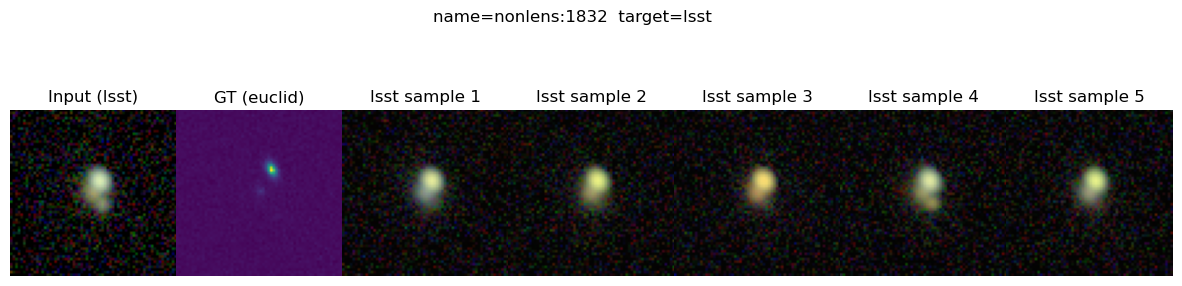

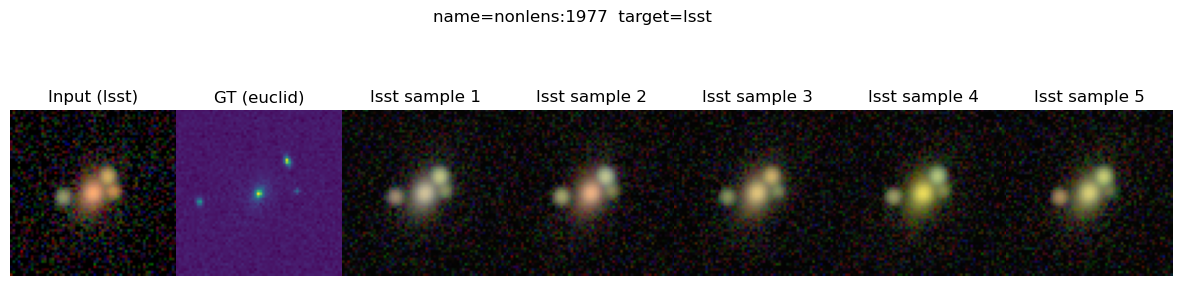

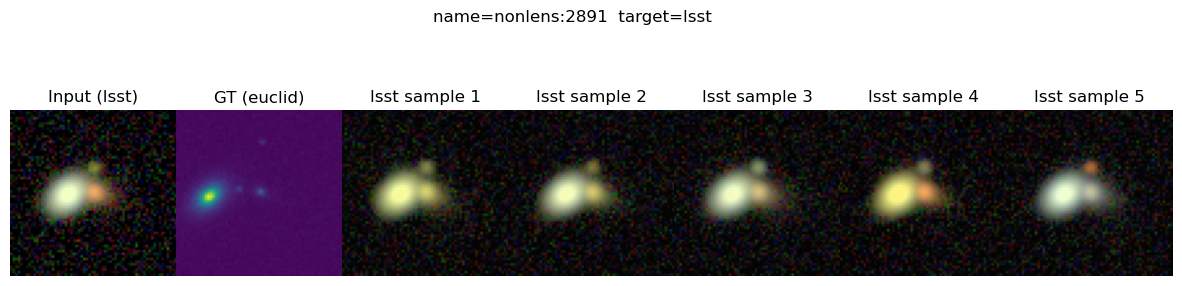

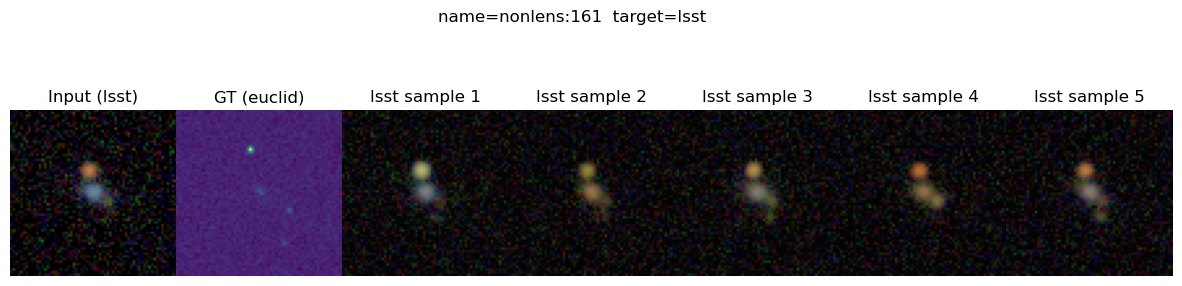

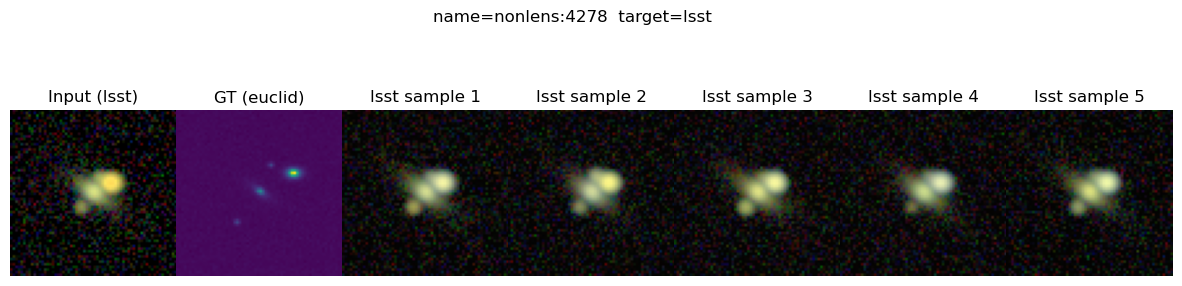

In [6]:
# --- Visualization (all samples) ---
K = len(sampling_seeds)
N = 5

for i in range(N):
    for tgt in preds.keys():
        # Use gridspec_kw to set horizontal space (wspace) to zero
        fig, axes = plt.subplots(
            1, 2 + int(K), 
            figsize=(3.0 * int(K), 3.5),
            gridspec_kw={'wspace': 0} # This removes the gap between columns
        )
        
        show_imgs(axes[0], source_all[i], f'Input ({source_key})')
        show_imgs(axes[1], target_all[i], f'GT ({target_key})')
        
        for k in range(int(K)):
            show_imgs(axes[2 + k], preds[tgt][k, i], f'{tgt} sample {k + 1}')
        
        # Note: If you have labels on the y-axis, they might overlap. 
        # You may need to turn off tick labels in your show_imgs function.
        
        fig.suptitle(f'name={names[i]}  target={tgt}', y=1.02)
        # Remove plt.tight_layout() as it adds padding back in
        plt.show()